In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix,find,csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.util import view_as_windows


In [2]:


INV_flag = 0

CDT_type0 = 0
CDT_K0 = 60
CDT_type = 0
CDT_K = 60


MakePrototypes = 1
splitTest2parts = 1

flag_binary0 = 0
LimNum1s = 50000
LimNum1s2nd = 2000
NumTrainSamples=60000
NumTestSamples =10000
MultiClassTraining = 1
NumberOfClasses = 10
TDS_start = 0.3
TDS_step = 0.05
TDS_end = 0.3

shy = 0
shy_step = 6
shx = 0
shx_step = 6

shiftCrossFlag = 0

deskew = 0
NumOfTrainingCycles = 200
StopTrainErrors = 1


Dc_start = 4
Dc_step = 1
Dc_end = 4
Dc_ratioXY_start = 1
Dc_ratioXY_step = 1
Dc_ratioXY_end = 1

Dc2_start = 1
Dc2_step = 1
Dc2_end = 1

seed = 101
seed_start = seed
number_experiments = 1
seed_finish = seed+number_experiments-1

y_dim,x_dim = 38,38
y2_dim,x2_dim =511,1
N = 1000000
seed = 101
cyc = 1

In [3]:
train_images = np.load("mnist_c_identity/train_images.npy")
train_labels = np.load("mnist_c_identity/train_labels.npy")

test_images = np.load("mnist_c_identity/test_images.npy")
test_labels = np.load("mnist_c_identity/test_labels.npy")

# train_images = np.squeeze(train_images)
# test_images = np.squeeze(test_images)

In [4]:
def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

def window2(arr, shape=(3, 3)):
    r_extra = np.floor(shape[0] / 2).astype(int)
    c_extra = np.floor(shape[1] / 2).astype(int)
    out = np.empty((arr.shape[0] + 2 * r_extra, arr.shape[1] + 2 * c_extra))
    out[:] = np.nan
    out[r_extra:-r_extra, c_extra:-c_extra] = arr
    view = rolling_window(out, shape)
    return view

In [5]:
row = []
col = []
data = np.array([1]*9)
for i in range(0,5,2):
    for j in range(0,5,2):
        row.append(i)
        col.append(j)
row = np.array(row)
col = np.array(col)
mask = csr_matrix((data, (row, col)), shape=(5, 5)).toarray()

In [6]:
def extract_local_binary_pattern(patch,mask_idx,pad=0):
    rows,cols = mask_idx
    bits = np.nan_to_num(patch,nan=pad)[:,rows,cols]
    median_bit = (np.median(bits,axis=-1,keepdims=True)).astype(np.uint8)
    bits -= median_bit
    bits = np.clip(bits, 0, 1)
    # bits = np.array([bits])
    return bits.dot(1 << np.arange(bits.shape[-1] - 1, -1, -1))
    

In [7]:
def get_lbp_features(patch):
    lbp_features = np.zeros(patch.shape[:3])
    for e in range(patch.shape[1]):
        for f in range(patch.shape[2]):
            lbp_features[:,e,f] = extract_local_binary_pattern(patch[:,e,f,:,:],[row,col])
    return np.array(lbp_features).reshape(patch.shape[:3])

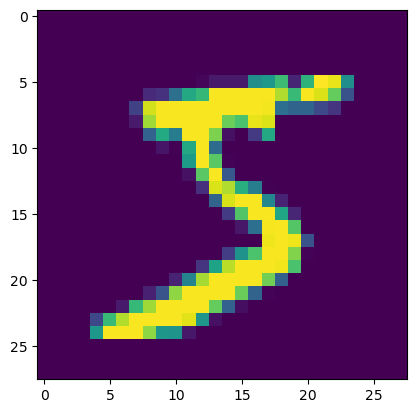

In [8]:
plt.imshow(np.array(train_images[0]).reshape((28,28)))

In [9]:
def cycle_permutation(N,seed=101):
    np.random.seed(seed)
    a = np.arange(N)
    for i in range(N-1):
        j = np.random.randint(i+1,N)
        a[[j,i]] = a[[i,j]]
    return a

In [10]:
def shifts_by_permutations_inverse_fast(inCVarray,perm_y,perm_x,perm_y1,perm_x1):
    inCVarray = perm_y[inCVarray.astype(int)]
    inCVarray = perm_x[inCVarray.astype(int)]
    inCVarray = perm_y1[inCVarray.astype(int)]
    outCVarray = perm_x1[inCVarray.astype(int)]
    return outCVarray

In [11]:
def prepare_permutations(ysz,xsz,Dc,Dc_ratio,N,seed,ysz1,xsz1,Dc2,Dc2_ratio,cyc):
    DcX = round(Dc*Dc_ratio)
    DcX2 = round(Dc2*Dc2_ratio)
    
    perm_y0 = cycle_permutation(N,seed)
    invperm_y0 = np.arange(N)
    invperm_y0[perm_y0] = np.arange(N)
    no_perm = np.arange(N).T
    perm_all = []
    
    perm_y = []
    perm_y.append(np.copy(perm_y0))
    perm_compos_col = np.copy(perm_y0)
    
    for k in range(1,ysz+Dc-1):
        perm_compos_col = np.copy(perm_y0[perm_compos_col])
        perm_y.append(np.copy(perm_compos_col))
    perm_y = np.array(perm_y).T
    
    
    perm_y_inv = []
    perm_y_inv.append(np.copy(invperm_y0))
    perm_compos_col_inv = np.copy(invperm_y0)
    for k in range(1,ysz+Dc-1):
        perm_compos_col_inv = np.copy(invperm_y0[perm_compos_col_inv])
        perm_y_inv.append(np.copy(perm_compos_col_inv))
    perm_y_inv = np.fliplr(np.array(perm_y_inv).T)
    perm_y_all = np.concatenate([perm_y_inv, np.expand_dims(no_perm,-1), perm_y],axis=-1)
    
    
    perm_x = []
    perm_x.append(np.copy(perm_compos_col))
    perm_compos_col1 = np.copy(perm_compos_col)
    
    for k in range(1,xsz+DcX-1):
        perm_compos_col1 = np.copy(perm_compos_col[perm_compos_col1])
        perm_x.append(np.copy(perm_compos_col[perm_x[k-1]]))
    perm_x = np.array(perm_x).T
    
    
    perm_x_inv = []
    perm_x_inv.append(np.copy(perm_compos_col_inv))
    perm_compos_col_inv1 = np.copy(perm_compos_col_inv)
    for k in range(xsz+DcX-1):
        perm_compos_col_inv1 = np.copy(perm_compos_col_inv[perm_compos_col_inv1])
        perm_x_inv.append(np.copy(perm_compos_col_inv[perm_x_inv[k-1]]))
        
    perm_x_inv = np.fliplr(np.array(perm_x_inv).T)
    perm_x_all = np.concatenate([perm_x_inv, np.expand_dims(no_perm,-1), perm_x],axis=-1)
    
    
    perm_y1 = []
    perm_y1.append(np.copy(perm_compos_col1))
    perm_y_inv1 = []
    perm_y_inv1.append(np.copy(perm_compos_col_inv1))

    perm_compos_col2 = np.copy(perm_compos_col1)
    perm_compos_col_inv2 = np.copy(perm_compos_col_inv1)
    
    if ysz > 1:
        for k in range(1,ysz1+Dc2-1):
            perm_compos_col2 = np.copy(perm_compos_col1[perm_compos_col2])
            perm_y1.append(np.copy(perm_compos_col1[perm_y1[k-1]]))
        
        perm_y1 = np.array(perm_y1).T
        
        for k in range(1,ysz1+Dc2-1):
            perm_compos_col_inv2 = np.copy(perm_compos_col_inv1[perm_compos_col_inv2])
            perm_y_inv1.append(np.copy(perm_compos_col_inv1[perm_y_inv1[k-1]]))
        
        perm_y_inv1 = np.fliplr(np.array(perm_y_inv1).T)
        perm_y_all1 = np.concatenate([perm_y_inv1, np.expand_dims(no_perm,-1), perm_y1],axis=-1)

     
    perm_x1 = []
    perm_x1.append(np.copy(perm_compos_col2))
    perm_x_inv1 = []
    perm_x_inv1.append(np.copy(perm_compos_col_inv2))

    perm_compos_col3 = np.copy(perm_compos_col2)
    perm_compos_col_inv3 = np.copy(perm_compos_col_inv2)
    if xsz > 1:
        for k in range(1,xsz1+DcX2-1):
            perm_compos_col3 = np.copy(perm_compos_col2[perm_compos_col3])
            perm_x1.append(np.copy(perm_compos_col2[perm_x1[k-1]]))
        
        perm_x1 = np.array(perm_x1).T
        
        for k in range(1,xsz1+DcX2-1):
            perm_compos_col_inv3 = np.copy(perm_compos_col_inv2[perm_compos_col_inv3])
            perm_x_inv1.append(np.copy(perm_compos_col_inv2[perm_x_inv1[k-1]]))
        
        perm_x_inv1 = np.fliplr(np.array(perm_x_inv1).T)
        perm_x_all1 = np.concatenate([perm_x_inv1, np.expand_dims(no_perm,-1), perm_x1],axis=-1)
    
    return perm_y_all, perm_x_all, perm_y_all1, perm_x_all1

In [12]:
def get_permutations(y_dim, x_dim, DC, DC_ratio, N, seed, y2_dim, x2_dim, DC2, DC2_ratio):
    np.random.seed(seed)
    DcX = round(DC*DC_ratio)
    DcX2 = round(DC2*DC2_ratio)
    
    permutation_y0 = cycle_permutation(N,seed)
    inverse_permutation_y0 = np.zeros(permutation_y0.shape[-1])
    inverse_permutation_y0[permutation_y0] = np.arange(permutation_y0.shape[-1])
    no_permutation = np.arange(N).T
    
    permutation_y = np.copy(permutation_y0).T
    perm_compos_col = np.copy(permutation_y0)
    for k in range(1,y_dim+DC-1):
        perm_compos_col = np.copy(permutation_y0[perm_compos_col])
        permutation_y = np.c_[permutation_y,perm_compos_col.T]
        
    
    permutation_y_inv = np.copy(inverse_permutation_y0).T
    perm_compos_col_inv = np.copy(inverse_permutation_y0)
    for k in range(1,y_dim+DC-1):
        perm_compos_col_inv = np.copy(inverse_permutation_y0[perm_compos_col_inv.astype(np.uint8)])
        permutation_y_inv = np.c_[permutation_y_inv,perm_compos_col_inv.T]
    
    permutation_y_inv = np.fliplr(permutation_y_inv)
    perm_y_all = np.concatenate([permutation_y_inv, np.expand_dims(no_permutation,-1), permutation_y],axis=1)
    
    
    permutation_x = np.expand_dims(np.copy(perm_compos_col).T,-1)
    perm_compos_col1 = np.copy(perm_compos_col)
    for k in range(1,x_dim+DcX-1):
        perm_compos_col1 = np.copy(perm_compos_col[perm_compos_col1.astype(np.uint8)])
        permutation_x = np.c_[permutation_x,perm_compos_col[permutation_x[:,k-1].flatten().astype(np.uint8)].T]
        
    
    permutation_x_inv = np.expand_dims(np.copy(perm_compos_col_inv).T,-1)
    perm_compos_col_inv1 = np.copy(perm_compos_col_inv)
    for k in range(1,x_dim+DcX-1):
        perm_compos_col_inv1 = np.copy(perm_compos_col_inv[perm_compos_col_inv1.astype(np.uint8)])
        permutation_x_inv = np.c_[permutation_x_inv,perm_compos_col_inv[permutation_x_inv[:,k-1].flatten().astype(np.uint8)].T]
    
    permutation_x_inv = np.fliplr(permutation_x_inv)
    perm_x_all = np.concatenate([permutation_x_inv, np.expand_dims(no_permutation,-1), permutation_x],axis=1)
    
    
    permutation_y1 = np.expand_dims(np.copy(perm_compos_col1).T,-1)
    perm_compos_col2 = np.copy(perm_compos_col1)
    for k in range(1,y2_dim+DC2-1):
        perm_compos_col2 = np.copy(perm_compos_col1[perm_compos_col2.astype(np.uint8)])
        permutation_y1 = np.c_[permutation_y1,perm_compos_col1[permutation_y1[:,k-1].flatten().astype(np.uint8)].T]
        
    
    permutation_y1_inv = np.expand_dims(np.copy(perm_compos_col_inv1).T,-1)
    perm_compos_col_inv2 = np.copy(perm_compos_col_inv1)
    for k in range(1,y2_dim+DC2-1):
        perm_compos_col_inv2 = np.copy(perm_compos_col_inv1[perm_compos_col_inv2.astype(np.uint8)])
        permutation_y1_inv = np.c_[permutation_y1_inv,perm_compos_col_inv1[permutation_y1_inv[:,k-1].flatten().astype(np.uint8)].T]
    
    permutation_y1_inv = np.fliplr(permutation_y1_inv)
    perm_y1_all = np.concatenate([permutation_y1_inv, np.expand_dims(no_permutation,-1), permutation_y1],axis=1)
    
    
    
    permutation_x1 = np.expand_dims(np.copy(perm_compos_col2).T, -1)
    perm_compos_col3 = np.copy(perm_compos_col2)
    for k in range(1,x2_dim+DcX2-1):
        perm_compos_col3 = np.copy(perm_compos_col2[perm_compos_col3.astype(np.uint8)])
        permutation_x1 = np.c_[permutation_x1,perm_compos_col2[permutation_x1[:,k-1].flatten().astype(np.uint8)].T]
        
    
    permutation_x1_inv = np.expand_dims(np.copy(perm_compos_col_inv2).T, -1)
    perm_compos_col_inv3 = np.copy(perm_compos_col_inv2)
    for k in range(1,x2_dim+DcX2-1):
        perm_compos_col_inv3 = np.copy(perm_compos_col_inv2[perm_compos_col_inv3.astype(np.uint8)])
        permutation_x1_inv = np.c_[permutation_x1_inv,perm_compos_col_inv2[permutation_x1_inv[:,k-1].flatten().astype(np.uint8)].T]
    
    permutation_x1_inv = np.fliplr(permutation_x1_inv)
    perm_x1_all = np.concatenate([permutation_x1_inv, np.expand_dims(no_permutation,-1), permutation_x1],axis=1)
    
    
    
    
    
    return perm_y_all, perm_x_all, perm_y1_all, perm_x1_all
    
    

In [13]:
# tyt = get_permutations(38,38,4,1,1000,101,511,1,1,1)
tyt = prepare_permutations(38,38,4,1,1000,101,511,1,1,1,1)

In [14]:
def make_codevector_matrix(y_dim, x_dim, DC, DC_ratio, N, seed, y2_dim, x2_dim, DC2, DC2_ratio,p,cyc):
    np.random.seed(seed)
    DcX = round(DC*DC_ratio)
    DcX2 = round(DC2*DC2_ratio)
    Np = round(p)
    num = 0
    
    perm_all = prepare_permutations(y_dim, x_dim, DC, DC_ratio, N, seed, y2_dim, x2_dim, DC2, DC2_ratio,cyc)
    perm_y_all = perm_all[0]
    perm_x_all = perm_all[1]
    perm_y_all1 = perm_all[2]
    perm_x_all1 = perm_all[3]
    
    # print(perm_y_all.shape)
    # print(perm_y_all.shape)
    # print(perm_x_all.shape)
    # print(perm_y_all1.shape)
    # print(perm_x_all1.shape)
    
    
    no_permutation = np.arange(N)
    base_permutation = np.random.permutation(N)
    base_vec = base_permutation[:Np]
    inCV1 = []
    
    if cyc == 1:
        perm_y0 = cycle_permutation(N,seed)
    if cyc == 0:
        perm_y0 = np.random.permutation(N)
    
    base_vec = np.copy(perm_y0[base_vec])
    
    # print(base_vec)
    for jj1 in range(DcX2):
        perm_x1 = perm_x_all1[:,jj1+x2_dim+DcX2-1]
        
        for ii1 in range(DC2):
            perm_y1 = perm_y_all1[:,ii1+y2_dim+DC2-1]
            
            for jj in range(DcX):
                perm_x = perm_x_all[:,jj+x_dim+DcX-1]
                
                for ii in range(DC):
                    
                    perm_y = perm_y_all[:,ii+y_dim+DC-1]
                    
                    inCV1.append(shifts_by_permutations_inverse_fast(base_vec,perm_y,perm_x,perm_y1,perm_x1))
                    num = num + Np
    inCV1 = np.array(inCV1).flatten()
    # print(inCV1)  
    
#     inCVy = np.zeros(DC*Np)
#     num = 0
#     for ii in range(DC):            
#         perm_y = perm_y_all[:,ii+y_dim+DC]

#         inCVy[num:num+Np] = shifts_by_permutations_inverse_fast(base_vec,perm_y,no_permutation,no_permutation,no_permutation)
#         num = num + Np
    
    
#     inCVx = np.zeros(DcX*Np)
#     num = 0
#     szCV = inCVy.shape[0]
#     for ii in range(DcX):            
#         perm_x = perm_x_all[:,ii+x_dim+DcX]

#         inCVx[num:num+Np] = shifts_by_permutations_inverse_fast(inCVy,no_permutation,perm_x,no_permutation,no_permutation)
#         num = num + szCV
    
#     inCVy1 = np.zeros(DC2*Np)
#     num = 0
#     szCV = inCVx.shape[0]
#     for ii in range(DC2):            
#         perm_y1 = perm_y_all1[:,ii+y2_dim+DC2]

#         inCVy1[num:num+szCV] = shifts_by_permutations_inverse_fast(inCVx,no_permutation,no_permutation,perm_y1,no_permutation)
#         num = num + szCV
    
    
#     inCVx1 = np.zeros(DcX2*Np)
#     num = 0
#     szCV = inCVx.shape[0]
#     for ii in range(DcX2):            
#         perm_x1 = perm_x_all1[:,ii+x2_dim+DcX2]

#         inCVx1[num:num+szCV] = shifts_by_permutations_inverse_fast(inCVx,no_permutation,no_permutation,no_permutation,perm_x1)
#         num = num + szCV
    
    
    ###########
    
#     inCVx1 = []
#     num = 0
#     szCV = base_vec.shape[0]
#     for ii in range(DcX2):            
#         perm_x1 = perm_x_all1[:,ii+x2_dim+DcX2]

#         inCVx1.append(shifts_by_permutations_inverse_fast(base_vec,no_permutation,no_permutation,no_permutation,perm_x1))
#         num = num + szCV
    
#     inCVx1 = np.array(inCVx1).flatten() 
    
#     inCVy1 = []
#     num = 0
#     szCV = inCVx1.shape[0]
#     for ii in range(DC2):            
#         perm_y1 = perm_y_all1[:,ii+y2_dim+DC2]

#         inCVy1.append(shifts_by_permutations_inverse_fast(inCVx1,no_permutation,no_permutation,perm_y1,no_permutation))
#         num = num + szCV
    
#     inCVy1 = np.array(inCVy1).flatten() 
    
#     inCVx = []
#     num = 0
#     szCV = inCVy1.shape[0]
#     for ii in range(DcX):            
#         perm_x = perm_x_all[:,ii+x_dim+DcX]

#         inCVx.append(shifts_by_permutations_inverse_fast(inCVy1,no_permutation,perm_x,no_permutation,no_permutation))
#         num = num + szCV
#     inCVx = np.array(inCVx).flatten() 
    
#     inCVy = []
#     num = 0
#     szCV = inCVx.shape[0]
#     for ii in range(DC):            
#         perm_y = perm_y_all[:,ii+y_dim+DC]
#         inCVy.append(shifts_by_permutations_inverse_fast(inCVx,perm_y,no_permutation,no_permutation,no_permutation))
#         num = num + szCV
#     inCVy = np.array(inCVy).flatten() 
    
#     print(szCV,DC,inCVx,inCVy.shape)
#     print(inCVy)
    codevector_matrix=np.zeros((y_dim,x_dim,y2_dim,x2_dim,DC*DcX*DC2*DcX2*Np),dtype=np.uint32)
    incv_copy = np.copy(inCV1)
    
    for jj1 in range(x2_dim):
        perm_x1 = perm_x_all1[:,jj1+x2_dim+DcX2-1]
        for ii1 in range(y2_dim):
            perm_y1 = perm_y_all1[:,ii1+y2_dim+DC2-1]
            # print(perm_y1.shape)
            for jj in range(x_dim):
                perm_x = perm_x_all[:,jj+x_dim+DcX-1]
                # print(perm_x.shape)
                for ii in range(y_dim):
                    perm_y = perm_y_all[:,ii+y_dim+DC-1]
                    # print(perm_y.shape)
                    # temp = shifts_by_permutations_inverse_fast(np.copy(inCV1),perm_y,perm_x,perm_y1,perm_x1)
                    codevector_matrix[ii,jj,ii1,jj1,:] = shifts_by_permutations_inverse_fast(np.copy(inCV1),perm_y,perm_x,perm_y1,perm_x1)
    
        
    return codevector_matrix, N
    

In [15]:
c_m, n = make_codevector_matrix(38+2*0, 38, 4, 1, N, 101, 511, 1, 1, 1,1,1)

In [16]:
np.unique(c_m)

array([     0,      1,      2, ..., 999997, 999998, 999999], dtype=uint32)

In [17]:
def make_sparsevector(nodes,nodes2,tensor,ysz,xsz,ysz2,xsz2,N,copy,bin_flag,LimNum1s,m,sz):
    num_nodes = nodes.shape[0]
    num_nodes2 = nodes2.shape[0]
    if nodes.shape != nodes2.shape:
        return
    out_codevector = np.zeros((nodes2.shape[1],tensor.shape[-1]))
    for i in range(nodes2.shape[1]):
        y = nodes[0,i]
        x = nodes[1,i]
        y2 = nodes2[1,i]
        x2 = nodes2[0,i]
        # print(y,x,y2,x2,tensor[y,x,int(y2),int(x2),:].sum())
        
        out_codevector[i,:] = tensor[y,x,int(y2),int(x2)]
    unique_index = np.unique(out_codevector.flatten())
    # print(out_codevector)
    if LimNum1s:
        num_non_zero = np.nonzero(unique_index)[0].shape[0]
        if num_non_zero > LimNum1s:
            unique_index = unique_index[:LimNum1s]
    # print(unique_index)
    # sparse_vector = csc_matrix(
    #     ([1]*unique_index.shape[0],
    #     ([m]*unique_index.shape[0],unique_index)),
    #     shape=((sz,N)),
    #     dtype=np.bool_
    # )
    return [m]*unique_index.shape[0],unique_index.tolist()
         

In [18]:
train_expanded = np.pad(train_images,((0,0),(2,2),(2,2),(0,0)),'constant',constant_values=np.nan)
train_patches = view_as_windows(train_expanded, (1,5,5,1))[...,0,:,:,0]
train_patches = np.squeeze(train_patches,axis=3)
train_lbp = get_lbp_features(train_patches)
train_lbp = np.pad(train_lbp,((0,0),(5,5),(5,5)),'constant',constant_values=0)


In [19]:
test_expanded = np.pad(test_images,((0,0),(2,2),(2,2),(0,0)),'constant',constant_values=np.nan)
test_patches = view_as_windows(test_expanded, (1,5,5,1))[...,0,:,:,0]
test_patches = np.squeeze(test_patches,axis=3)
test_lbp = get_lbp_features(test_patches)
test_lbp = np.pad(test_lbp,((0,0),(5,5),(5,5)),'constant',constant_values=0)


In [49]:

train_s_rows = []
train_s_cols = []
for m,a in enumerate(tqdm(train_lbp)):
    a_nonzero = np.nonzero(a)
    arr1 = np.array([a_nonzero[0],a_nonzero[1]])
    a_values = a[a_nonzero]
    arr2 = np.array([[0]*a_nonzero[1].shape[0], a_values])
    sparse_vec = make_sparsevector(arr1,arr2,c_m,38,38,511,1,N,0,0,2000,m,NumTrainSamples)
    # print(sparse_vec)
    train_s_rows += sparse_vec[0]
    train_s_cols += sparse_vec[1]    
    
train_sparse = csr_matrix(([1]*len(train_s_cols),(train_s_rows,train_s_cols)),
                            shape=((NumTrainSamples,N)),
                             dtype=np.bool_
                        )

100%|██████████████████████████████████████| 60000/60000 [01:01<00:00, 974.49it/s]


In [48]:

test_s_rows = []
test_s_cols = []
for m,a in enumerate(tqdm(test_lbp)):
    a_nonzero = np.nonzero(a)
    arr1 = np.array([a_nonzero[0],a_nonzero[1]])
    a_values = a[a_nonzero]
    arr2 = np.array([[0]*a_nonzero[1].shape[0], a_values])
    sparse_vec = make_sparsevector(arr1,arr2,c_m,38,38,511,1,N,0,0,2000,m,NumTestSamples)
    # print(sparse_vec)
    test_s_rows += sparse_vec[0]
    test_s_cols += sparse_vec[1]
    
test_sparse = csr_matrix(([1]*len(test_s_cols),(test_s_rows,test_s_cols)),
                            shape=((NumTestSamples,N)),
                             dtype=np.bool_
                        )

100%|█████████████████████████████████████| 10000/10000 [00:09<00:00, 1027.99it/s]


In [45]:
# del train_sparse
import gc
gc.collect()

2957

In [40]:
test_sparse.sum(axis=1)

matrix([[200],
        [200],
        [200],
        ...,
        [200],
        [200],
        [200]])

In [42]:
for Dc2 in range(Dc2_start,Dc2_end+1,Dc2_step):
    Dc2_ratioXY=1/Dc2
    for Dc in range(Dc_start,Dc_end+1,Dc_step):
        for Dc_ratioXY in range(Dc_ratioXY_start,Dc_ratioXY_end+1,Dc_ratioXY_step):
            TestErrorsIterIseed = []
            for seed in range(seed_start,seed_finish+1):
                iseed = seed-seed_start+1
                
                
                LimitMatrix = 0 # 1 use [0, ~360000] for weights, 0 - use + and - weights
                TrainSparse = -1
                code_sparse_flag = 1
                p_drop = 0.0 #dropout
                cast_do = 1
                maxnorm_flag = -1 #2 #-1
                
                UseReadyMatrix = 0     # 1 - Use already trained matrix from file
                ContinueTrainMatrix = 0# 1 - Continue training using matrix from file. Requires UseReadyMatrix = 0
                StopTrain = 0.0 # fraction of first iteration errors to stop training # 0.01



                # Training
                #TDS = 0.7 # initial "training defense space"
                TDS_decay = 0.009 # decreasing TDS #0.95 #0.9 #new version 18.01.2010
                TDS_iter = 200 #50 # 5#??decreasing each TDS_iter iterations of training
                delta = 1.0 # matrix increment - decrement step
                #NumOfTrainingCycles = 50 #50
                # Changed number of samples per iteration from mean to max to 14.01
                InitMatrix = 0 # Initial matrix values. 0 or 1

                cycleBegin = 1 
                cycleEnd = 1 # è
                
                for cycle in range(cycleBegin,cycleEnd+1):
                    # perm_all = prepare_permutations(y_dim,x_dim,Dc,Dc_ratioXY,N,seed,y2_dim,x2_dim,Dc2,Dc2_ratioXY,cyc)
                    # perm_y_all = perm_all[0]
                    # perm_x_all = perm_all[1]
                    # perm_y_all1 = perm_all[2]
                    # perm_x_all1 = perm_all[3]
                    
                    TestErrorsIterSplit = []
                    NumTestSamplesPart = NumTestSamples / splitTest2parts
                    num_shx = np.arange(-shx,shx+1,shx_step)
                    num_shy = np.arange(-shy,shy+1,shy_step)
                    num_shifts = num_shx.shape[-1] * num_shy.shape[-1]
                    
                    for spl in range(splitTest2parts+1):
                        spVectors0TestShifts = []
                        spVectors0Train_Lim = []
                        if num_shifts == 1 and LimNum1s2nd < LimNum1s:
                            spVectors0TestShifts_rows = []
                            spVectors0TestShifts_cols = []
                            
#                             for m in tqdm(range(NumTestSamples)):
#                                 ind = find(test_sparse[m])
#                                 spVectors0TestShifts_rows+= [m]*len(ind[0][:LimNum1s2nd].tolist())
#                                 spVectors0TestShifts_cols+=ind[1][:LimNum1s2nd].tolist()
                            
#                             spVectors0TestShifts = csc_matrix(([1]*len(spVectors0TestShifts_rows),
#                                                                 (spVectors0TestShifts_rows,spVectors0TestShifts_cols)),
#                                                                 shape=((NumTestSamples,N)),
#                                                                 dtype=np.bool_
#                                                             )
#                             print(spVectors0TestShifts.shape)
#                             spVectors0Train_Lim_rows = []
#                             spVectors0Train_Lim_cols = []
#                             for m in tqdm(range(NumTrainSamples)):
#                                 ind = find(train_sparse[m])
#                                 spVectors0Train_Lim_rows+= [m]*len(ind[0][:LimNum1s2nd].tolist())
#                                 spVectors0Train_Lim_cols+=ind[1][:LimNum1s2nd].tolist()
                            
#                             spVectors0Train_Lim = csc_matrix(([1]*len(spVectors0Train_Lim_rows),
#                                                                 (spVectors0Train_Lim_rows,spVectors0Train_Lim_cols)),
#                                                                 shape=((NumTrainSamples,N)),
#                                                                 dtype=np.bool_
#                                                             )
#                             print(spVectors0Train_Lim.shape)
                        
                        for TDS in np.arange(TDS_start,TDS_end+TDS_step,TDS_step):
                            for Winner4shifts in range(1):
                                for thrWinners in range(-1000,-999):
                                    TheActivations0 = np.zeros([NumberOfClasses,1])
                                    TheActivations = np.zeros([NumberOfClasses,1])
                                    TheClasses = np.arange(NumberOfClasses)
                                    
                                    currentTDS = TDS
                                    TrainingErrors = 0
                                    TrainingCorrect = 0
                                    tdsind = 0
                                    TheMatrix = np.zeros((NumberOfClasses,N))
                                    testErrorIter = []
                                    perm = np.arange(NumTrainSamples)
                                    for tc in tqdm(range(NumOfTrainingCycles)):
                                        TrainingErrors = 0
                                        TrainingCorrect = 0
                                        if MakePrototypes == 1 and tc == 0:
                                            for ppp in range(NumberOfClasses):
                                                TheMatrix[ppp,:] = train_sparse[train_labels==ppp].sum(axis=0)/NumberOfClasses
                                        else:
                                            tce = 0
                                            ClassLabels = np.copy(train_labels)
                                            for fc in range(NumTrainSamples):
                                                sample_num = perm[fc]
                                                if code_sparse_flag == 1:
                                                    x = train_sparse[sample_num]
                                                    TheActivations0 = (TheMatrix @ x.A.T).flatten()
                                                if maxnorm_flag == -1:
                                                    TheActivations = TheActivations0
                                                
                                                TheTrueClass=ClassLabels[fc]
                                                TheActivations[TheTrueClass] = TheActivations[TheTrueClass]*(1.0-currentTDS)
                                                ind2unlearn = TheActivations > TheActivations[TheTrueClass]
                                                
                                                if TheActivations[0] > TheActivations[1]:
                                                    TheFirstActivation  = TheActivations[0]
                                                    TheFirstClass  = TheClasses[0]
                                                else:
                                                    TheFirstActivation  = TheActivations[1]
                                                    TheFirstClass  = TheClasses[1]
                                                
                                                for i in range(1,NumberOfClasses):
                                                    if TheActivations[i] > TheFirstActivation:
                                                        TheFirstActivation = TheActivations[i]
                                                        TheFirstClass = TheClasses[i]
                                                if code_sparse_flag == 1:
                                                    if TheFirstClass != TheTrueClass:
                                                        TrainingErrors += 1
                                                        tce += 1
                                                        # nnz1  = x.count_nonzero()
                                                        if MultiClassTraining == 1:
                                                            TheMatrix[TheTrueClass,x.A.flatten()]  += delta
                                                            num_wrong_class = sum(ind2unlearn.flatten())
                                                            if num_wrong_class > 0:
                                                                for r in ind2unlearn.flatten().nonzero()[0]:
                                                                    TheMatrix[r ,x.A.flatten()] -= delta/num_wrong_class
                                                            else:
                                                                TheMatrix[:,x.A.flatten()] -= delta/10
                                                    else:
                                                        TrainingCorrect += 1
                                                # if fc %1000==0:
                                                #     print(fc,TrainingCorrect,TrainingErrors)
                                        print("Train Correct:",TrainingCorrect,"Train Error:",TrainingErrors)
                                        
                                        
                                        TestErrors = 0
                                        TestCorrect = 0
                                        TestErrorsRel = 0
                                        TestCorrectRel = 0
                                        TheActivations = np.zeros([NumberOfClasses,1])
                                        TheClasses = np.arange(NumberOfClasses)
                                        ClassLabelsTest = test_labels
                                        
                                        for ii in range(NumTestSamples):
                                            x = test_sparse[ii]
                                            TheActivations = (TheMatrix @ x.A.T).flatten()
                                            TheTrueClass=ClassLabelsTest[ii]
                                            TheFirstActivation = TheActivations[0]
                                            TheFirstClass = TheClasses[0]
                                            for i in range(1,NumberOfClasses):
                                                if TheActivations[i] > TheFirstActivation:
                                                    TheFirstActivation = TheActivations[i]
                                                    TheFirstClass = TheClasses[i]
                                            if TheFirstClass != TheTrueClass:
                                                TestErrors = TestErrors + 1
                                            else:
                                                TestCorrect = TestCorrect + 1
                                        print("Test Correct:", TestCorrect,"Test Errors:",TestErrors)
                                        tdsind = tdsind + 1
                                        if tdsind >= TDS_iter:
                                            currentTDS = currentTDS *(1.0 - TDS_decay)
                                            tdsind = 0


  0%|                                                     | 0/200 [00:00<?, ?it/s]

Train Correct: 0 Train Error: 0


  0%|▏                                            | 1/200 [00:05<17:43,  5.34s/it]

Test Correct: 6872 Test Errors: 3128
Train Correct: 24595 Train Error: 35405


  1%|▍                                          | 2/200 [02:14<4:17:15, 77.96s/it]

Test Correct: 8100 Test Errors: 1900
Train Correct: 33691 Train Error: 26309


  2%|▋                                          | 3/200 [03:51<4:44:20, 86.60s/it]

Test Correct: 8065 Test Errors: 1935
Train Correct: 35788 Train Error: 24212


  2%|▊                                          | 4/200 [05:13<4:38:05, 85.13s/it]

Test Correct: 8029 Test Errors: 1971
Train Correct: 36898 Train Error: 23102


  2%|█                                          | 5/200 [06:41<4:39:30, 86.00s/it]

Test Correct: 8018 Test Errors: 1982
Train Correct: 37540 Train Error: 22460


  3%|█▎                                         | 6/200 [08:12<4:43:11, 87.58s/it]

Test Correct: 8005 Test Errors: 1995
Train Correct: 37987 Train Error: 22013


  4%|█▌                                         | 7/200 [09:31<4:32:54, 84.84s/it]

Test Correct: 7992 Test Errors: 2008
Train Correct: 38310 Train Error: 21690


  4%|█▋                                         | 8/200 [10:51<4:26:51, 83.39s/it]

Test Correct: 7977 Test Errors: 2023
Train Correct: 38549 Train Error: 21451


  4%|█▉                                         | 9/200 [12:17<4:27:45, 84.11s/it]

Test Correct: 7975 Test Errors: 2025
Train Correct: 38690 Train Error: 21310


  5%|██                                        | 10/200 [13:37<4:22:23, 82.86s/it]

Test Correct: 7964 Test Errors: 2036
Train Correct: 38817 Train Error: 21183


  6%|██▎                                       | 11/200 [15:01<4:22:14, 83.25s/it]

Test Correct: 7960 Test Errors: 2040
Train Correct: 38913 Train Error: 21087


  6%|██▌                                       | 12/200 [17:01<4:56:07, 94.51s/it]

Test Correct: 7953 Test Errors: 2047
Train Correct: 38998 Train Error: 21002


  6%|██▋                                       | 13/200 [18:37<4:55:50, 94.92s/it]

Test Correct: 7945 Test Errors: 2055
Train Correct: 39069 Train Error: 20931


  7%|██▉                                       | 14/200 [19:55<4:38:44, 89.92s/it]

Test Correct: 7943 Test Errors: 2057
Train Correct: 39131 Train Error: 20869


  8%|███▏                                      | 15/200 [21:17<4:29:02, 87.26s/it]

Test Correct: 7941 Test Errors: 2059
Train Correct: 39186 Train Error: 20814


  8%|███▎                                      | 16/200 [22:40<4:23:51, 86.04s/it]

Test Correct: 7937 Test Errors: 2063
Train Correct: 39231 Train Error: 20769


  8%|███▌                                      | 17/200 [24:01<4:17:38, 84.47s/it]

Test Correct: 7934 Test Errors: 2066
Train Correct: 39255 Train Error: 20745


  9%|███▊                                      | 18/200 [25:24<4:15:12, 84.13s/it]

Test Correct: 7931 Test Errors: 2069
Train Correct: 39288 Train Error: 20712


 10%|███▉                                      | 19/200 [26:48<4:13:25, 84.01s/it]

Test Correct: 7932 Test Errors: 2068
Train Correct: 39333 Train Error: 20667


 10%|████▏                                     | 20/200 [28:12<4:12:15, 84.09s/it]

Test Correct: 7928 Test Errors: 2072
Train Correct: 39356 Train Error: 20644


 10%|████▍                                     | 21/200 [29:35<4:10:06, 83.83s/it]

Test Correct: 7927 Test Errors: 2073
Train Correct: 39380 Train Error: 20620


 11%|████▌                                     | 22/200 [30:56<4:06:04, 82.95s/it]

Test Correct: 7928 Test Errors: 2072
Train Correct: 39384 Train Error: 20616


 12%|████▊                                     | 23/200 [32:23<4:07:48, 84.00s/it]

Test Correct: 7928 Test Errors: 2072
Train Correct: 39421 Train Error: 20579


 12%|█████                                     | 24/200 [33:41<4:01:30, 82.33s/it]

Test Correct: 7928 Test Errors: 2072
Train Correct: 39439 Train Error: 20561


 12%|█████▎                                    | 25/200 [34:59<3:56:16, 81.01s/it]

Test Correct: 7926 Test Errors: 2074
Train Correct: 39449 Train Error: 20551


 13%|█████▍                                    | 26/200 [36:17<3:52:30, 80.18s/it]

Test Correct: 7922 Test Errors: 2078
Train Correct: 39476 Train Error: 20524


 14%|█████▋                                    | 27/200 [37:37<3:51:08, 80.16s/it]

Test Correct: 7920 Test Errors: 2080
Train Correct: 39489 Train Error: 20511


 14%|█████▉                                    | 28/200 [39:04<3:55:41, 82.22s/it]

Test Correct: 7919 Test Errors: 2081
Train Correct: 39495 Train Error: 20505


 14%|██████                                    | 29/200 [40:28<3:55:24, 82.60s/it]

Test Correct: 7918 Test Errors: 2082
Train Correct: 39524 Train Error: 20476


 15%|██████▎                                   | 30/200 [41:46<3:50:16, 81.27s/it]

Test Correct: 7916 Test Errors: 2084
Train Correct: 39516 Train Error: 20484


 16%|██████▌                                   | 31/200 [43:01<3:43:55, 79.50s/it]

Test Correct: 7914 Test Errors: 2086
Train Correct: 39543 Train Error: 20457


 16%|██████▋                                   | 32/200 [44:20<3:42:02, 79.30s/it]

Test Correct: 7913 Test Errors: 2087
Train Correct: 39544 Train Error: 20456


 16%|██████▉                                   | 33/200 [45:39<3:40:42, 79.30s/it]

Test Correct: 7911 Test Errors: 2089
Train Correct: 39552 Train Error: 20448


 17%|███████▏                                  | 34/200 [47:03<3:43:11, 80.67s/it]

Test Correct: 7910 Test Errors: 2090
Train Correct: 39544 Train Error: 20456


 18%|███████▎                                  | 35/200 [48:24<3:42:11, 80.80s/it]

Test Correct: 7906 Test Errors: 2094
Train Correct: 39564 Train Error: 20436


 18%|███████▌                                  | 36/200 [49:45<3:40:20, 80.61s/it]

Test Correct: 7906 Test Errors: 2094
Train Correct: 39556 Train Error: 20444


 18%|███████▊                                  | 37/200 [51:06<3:39:17, 80.72s/it]

Test Correct: 7904 Test Errors: 2096
Train Correct: 39569 Train Error: 20431


 19%|███████▉                                  | 38/200 [52:40<3:49:27, 84.99s/it]

Test Correct: 7902 Test Errors: 2098
Train Correct: 39598 Train Error: 20402


 20%|████████▏                                 | 39/200 [54:24<4:02:39, 90.43s/it]

Test Correct: 7900 Test Errors: 2100
Train Correct: 39591 Train Error: 20409


 20%|████████▍                                 | 40/200 [56:06<4:10:24, 93.91s/it]

Test Correct: 7900 Test Errors: 2100
Train Correct: 39577 Train Error: 20423


 20%|████████▌                                 | 41/200 [57:55<4:21:22, 98.63s/it]

Test Correct: 7898 Test Errors: 2102
Train Correct: 39593 Train Error: 20407


 21%|████████▌                                | 42/200 [59:56<4:37:04, 105.22s/it]

Test Correct: 7895 Test Errors: 2105
Train Correct: 39622 Train Error: 20378


 22%|████████▍                              | 43/200 [1:01:42<4:36:23, 105.62s/it]

Test Correct: 7896 Test Errors: 2104
Train Correct: 39594 Train Error: 20406


 22%|████████▌                              | 44/200 [1:03:38<4:42:03, 108.49s/it]

Test Correct: 7896 Test Errors: 2104
Train Correct: 39612 Train Error: 20388


 22%|████████▊                              | 45/200 [1:05:33<4:45:40, 110.58s/it]

Test Correct: 7895 Test Errors: 2105
Train Correct: 39612 Train Error: 20388


 22%|█████████                               | 45/200 [1:07:37<3:52:57, 90.18s/it]


KeyboardInterrupt: 

In [30]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/prathnayakam/opt/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs =

In [104]:
train_sparse[0].count_nonzero()

3252

In [66]:
ind2unlearn.flatten().nonzero()

(array([1, 2, 3, 4, 6, 7, 8]),)

In [29]:
TheMatrix.shape,train_sparse[sample_num].A.T.flatten().shape

((10, 1000000), (1000000,))

In [24]:
import scipy

In [ ]:
5.049883e-01

In [25]:
%%timeit 

scipy.sparse.csr_matrix.dot(TheMatrix,train_sparse[sample_num].T)

20.8 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit

TheMatrix@train_sparse[sample_num].A.T

3.5 ms ± 98.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
train_sparse[sample_num]

<1x1000000 sparse matrix of type '<class 'numpy.bool_'>'
	with 2000 stored elements in Compressed Sparse Row format>

In [36]:
def mult_dense_with_sparse(A, x):
    return (A[:,x.nonzero()[0]] @ x.toarray()[x.nonzero()[0]]).T[0]

In [47]:
%%timeit

mult_dense_with_sparse(TheMatrix, train_sparse[sample_num].T)

3.45 ms ± 654 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
# %%timeit

train_sparse[sample_num].dot(TheMatrix.T).T

array([[319006.48531746],
       [244839.21785714],
       [556435.94563492],
       [396256.26666666],
       [113686.8547619 ],
       [240280.91626984],
       [109071.56706349],
       [347702.30952381],
       [245196.03174603],
       [238046.60515873]])

In [ ]:
for Dc2 in range(Dc2_start,Dc2_end+1,Dc2_step):
    Dc2_ratioXY=1/Dc2
    for Dc in range(Dc_start,Dc_end+1,Dc_step):
        for Dc_ratioXY in range(Dc_ratioXY_start,Dc_ratioXY_end+1,Dc_ratioXY_step):
            TestErrorsIterIseed = []
            for seed in range(seed_start,seed_finish+1):
                iseed = seed-seed_start+1
                
                
                LimitMatrix = 0 # 1 use [0, ~360000] for weights, 0 - use + and - weights
                TrainSparse = -1
                code_sparse_flag = 1
                p_drop = 0.0 #dropout
                cast_do = 1
                maxnorm_flag = -1 #2 #-1
                
                UseReadyMatrix = 0     # 1 - Use already trained matrix from file
                ContinueTrainMatrix = 0# 1 - Continue training using matrix from file. Requires UseReadyMatrix = 0
                StopTrain = 0.0 # fraction of first iteration errors to stop training # 0.01



                # Training
                #TDS = 0.7 # initial "training defense space"
                TDS_decay = 0.009 # decreasing TDS #0.95 #0.9 #new version 18.01.2010
                TDS_iter = 200 #50 # 5#??decreasing each TDS_iter iterations of training
                delta = 1.0 # matrix increment - decrement step
                #NumOfTrainingCycles = 50 #50
                # Changed number of samples per iteration from mean to max to 14.01
                InitMatrix = 0 # Initial matrix values. 0 or 1

                cycleBegin = 1 
                cycleEnd = 1 # è
                
                for cycle in range(cycleBegin,cycleEnd+1):
                    # perm_all = prepare_permutations(y_dim,x_dim,Dc,Dc_ratioXY,N,seed,y2_dim,x2_dim,Dc2,Dc2_ratioXY,cyc)
                    # perm_y_all = perm_all[0]
                    # perm_x_all = perm_all[1]
                    # perm_y_all1 = perm_all[2]
                    # perm_x_all1 = perm_all[3]
                    
                    TestErrorsIterSplit = []
                    NumTestSamplesPart = NumTestSamples / splitTest2parts
                    num_shx = np.arange(-shx,shx+1,shx_step)
                    num_shy = np.arange(-shy,shy+1,shy_step)
                    num_shifts = num_shx.shape[-1] * num_shy.shape[-1]
                    
                    for spl in range(splitTest2parts+1):
                        spVectors0TestShifts = []
                        spVectors0Train_Lim = []
                        if num_shifts == 1 and LimNum1s2nd < LimNum1s:
                            spVectors0TestShifts_rows = []
                            spVectors0TestShifts_cols = []
                            
#                             for m in tqdm(range(NumTestSamples)):
#                                 ind = find(test_sparse[m])
#                                 spVectors0TestShifts_rows+= [m]*len(ind[0][:LimNum1s2nd].tolist())
#                                 spVectors0TestShifts_cols+=ind[1][:LimNum1s2nd].tolist()
                            
#                             spVectors0TestShifts = csc_matrix(([1]*len(spVectors0TestShifts_rows),
#                                                                 (spVectors0TestShifts_rows,spVectors0TestShifts_cols)),
#                                                                 shape=((NumTestSamples,N)),
#                                                                 dtype=np.bool_
#                                                             )
#                             print(spVectors0TestShifts.shape)
#                             spVectors0Train_Lim_rows = []
#                             spVectors0Train_Lim_cols = []
#                             for m in tqdm(range(NumTrainSamples)):
#                                 ind = find(train_sparse[m])
#                                 spVectors0Train_Lim_rows+= [m]*len(ind[0][:LimNum1s2nd].tolist())
#                                 spVectors0Train_Lim_cols+=ind[1][:LimNum1s2nd].tolist()
                            
#                             spVectors0Train_Lim = csc_matrix(([1]*len(spVectors0Train_Lim_rows),
#                                                                 (spVectors0Train_Lim_rows,spVectors0Train_Lim_cols)),
#                                                                 shape=((NumTrainSamples,N)),
#                                                                 dtype=np.bool_
#                                                             )
#                             print(spVectors0Train_Lim.shape)
                        
                        for TDS in np.arange(TDS_start,TDS_end+TDS_step,TDS_step):
                            for Winner4shifts in range(1):
                                for thrWinners in range(-1000,-999):
                                    TheActivations0 = np.zeros([NumberOfClasses,1])
                                    TheActivations = np.zeros([NumberOfClasses,1])
                                    TheClasses = np.arange(NumberOfClasses)
                                    
                                    currentTDS = TDS
                                    TrainingErrors = 0
                                    TrainingCorrect = 0
                                    tdsind = 0
                                    TheMatrix = np.zeros((NumberOfClasses,N),dtype=np.float32)
                                    testErrorIter = []
                                    perm = np.arange(NumTrainSamples)
                                    for tc in tqdm(range(NumOfTrainingCycles)):
                                        TrainingErrors = 0
                                        TrainingCorrect = 0
                                        if MakePrototypes == 1 and tc == 0:
                                            for ppp in range(NumberOfClasses):
                                                TheMatrix[ppp,:] = train_sparse[train_labels==ppp].sum(axis=0)/NumberOfClasses
                                        else:
                                            tce = 0
                                            ClassLabels = np.copy(train_labels)
                                            for fc in range(NumTrainSamples):
                                                sample_num = perm[fc]
                                                if code_sparse_flag == 1:
                                                    x = train_sparse[sample_num]
                                                    # TheActivations0 = (TheMatrix @ x.A.T).flatten()
                                                    TheActivations0 = mult_dense_with_sparse(TheMatrix, x.T)
                                                if maxnorm_flag == -1:
                                                    TheActivations = TheActivations0
                                                
                                                TheTrueClass=ClassLabels[fc]
                                                TheActivations[TheTrueClass] = TheActivations[TheTrueClass]*(1.0-currentTDS)
                                                ind2unlearn = TheActivations > TheActivations[TheTrueClass]
                                                
                                                if TheActivations[0] > TheActivations[1]:
                                                    TheFirstActivation  = TheActivations[0]
                                                    TheFirstClass  = TheClasses[0]
                                                else:
                                                    TheFirstActivation  = TheActivations[1]
                                                    TheFirstClass  = TheClasses[1]
                                                
                                                for i in range(1,NumberOfClasses):
                                                    if TheActivations[i] > TheFirstActivation:
                                                        TheFirstActivation = TheActivations[i]
                                                        TheFirstClass = TheClasses[i]
                                                if code_sparse_flag == 1:
                                                    if TheFirstClass != TheTrueClass:
                                                        TrainingErrors += 1
                                                        tce += 1
                                                        # nnz1  = x.count_nonzero()
                                                        if MultiClassTraining == 1:
                                                            TheMatrix[TheTrueClass,x.A.flatten()]  += delta
                                                            num_wrong_class = sum(ind2unlearn.flatten())
                                                            if num_wrong_class > 0:
                                                                for r in ind2unlearn.flatten().nonzero()[0]:
                                                                    TheMatrix[r ,x.A.flatten()] -= delta/num_wrong_class
                                                            else:
                                                                TheMatrix[:,x.A.flatten()] -= delta/10
                                                    else:
                                                        TrainingCorrect += 1
                                                # if fc %1000==0:
                                                #     print(fc,TrainingCorrect,TrainingErrors)
                                        print("Train Correct:",TrainingCorrect,"Train Error:",TrainingErrors)
                                        
                                        
                                        TestErrors = 0
                                        TestCorrect = 0
                                        TestErrorsRel = 0
                                        TestCorrectRel = 0
                                        TheActivations = np.zeros([NumberOfClasses,1])
                                        TheClasses = np.arange(NumberOfClasses)
                                        ClassLabelsTest = test_labels
                                        
                                        for ii in range(NumTestSamples):
                                            x = test_sparse[ii]
                                            TheActivations = mult_dense_with_sparse(TheMatrix, x.T)
                                            TheTrueClass=ClassLabelsTest[ii]
                                            TheFirstActivation = TheActivations[0]
                                            TheFirstClass = TheClasses[0]
                                            for i in range(1,NumberOfClasses):
                                                if TheActivations[i] > TheFirstActivation:
                                                    TheFirstActivation = TheActivations[i]
                                                    TheFirstClass = TheClasses[i]
                                            if TheFirstClass != TheTrueClass:
                                                TestErrors = TestErrors + 1
                                            else:
                                                TestCorrect = TestCorrect + 1
                                        print("Test Correct:", TestCorrect,"Test Errors:",TestErrors)
                                        tdsind = tdsind + 1
                                        if tdsind >= TDS_iter:
                                            currentTDS = currentTDS *(1.0 - TDS_decay)
                                            tdsind = 0


  0%|                                                     | 0/200 [00:00<?, ?it/s]

Train Correct: 0 Train Error: 0


  0%|▏                                          | 1/200 [00:27<1:30:06, 27.17s/it]

Test Correct: 7675 Test Errors: 2325
Train Correct: 32353 Train Error: 27647


  1%|▍                                        | 2/200 [11:25<21:54:30, 398.34s/it]

Test Correct: 9548 Test Errors: 452
Train Correct: 44095 Train Error: 15905


  2%|▌                                        | 3/200 [18:16<22:07:34, 404.34s/it]

Test Correct: 9629 Test Errors: 371
Train Correct: 47269 Train Error: 12731


  2%|▊                                        | 4/200 [23:30<20:03:46, 368.50s/it]

Test Correct: 9679 Test Errors: 321
Train Correct: 48958 Train Error: 11042


  2%|█                                        | 5/200 [28:18<18:23:08, 339.43s/it]

Test Correct: 9708 Test Errors: 292
Train Correct: 50002 Train Error: 9998


  3%|█▏                                       | 6/200 [32:52<17:06:20, 317.42s/it]

Test Correct: 9727 Test Errors: 273
Train Correct: 50796 Train Error: 9204


  4%|█▍                                       | 7/200 [37:15<16:02:53, 299.34s/it]

Test Correct: 9736 Test Errors: 264
Train Correct: 51419 Train Error: 8581


  4%|█▋                                       | 8/200 [41:28<15:10:51, 284.64s/it]

Test Correct: 9753 Test Errors: 247
Train Correct: 51957 Train Error: 8043


  4%|█▊                                       | 9/200 [45:35<14:28:54, 272.95s/it]

Test Correct: 9765 Test Errors: 235
Train Correct: 52341 Train Error: 7659


  5%|██                                      | 10/200 [50:05<14:21:18, 271.99s/it]

Test Correct: 9772 Test Errors: 228
Train Correct: 52697 Train Error: 7303


  6%|██▏                                     | 11/200 [54:56<14:35:09, 277.83s/it]

Test Correct: 9776 Test Errors: 224
Train Correct: 52982 Train Error: 7018


  6%|██▍                                     | 12/200 [58:52<13:50:34, 265.08s/it]

Test Correct: 9783 Test Errors: 217
Train Correct: 53259 Train Error: 6741


  6%|██▍                                   | 13/200 [1:02:44<13:14:56, 255.06s/it]

Test Correct: 9791 Test Errors: 209
Train Correct: 53501 Train Error: 6499


  7%|██▋                                   | 14/200 [1:06:30<12:44:03, 246.47s/it]

Test Correct: 9795 Test Errors: 205
Train Correct: 53707 Train Error: 6293


  8%|██▊                                   | 15/200 [1:10:15<12:19:21, 239.79s/it]

Test Correct: 9799 Test Errors: 201
Train Correct: 53872 Train Error: 6128


  8%|███                                   | 16/200 [1:13:59<12:00:37, 234.99s/it]

Test Correct: 9805 Test Errors: 195
Train Correct: 54067 Train Error: 5933


  8%|███▏                                  | 17/200 [1:17:38<11:42:16, 230.25s/it]

Test Correct: 9807 Test Errors: 193
Train Correct: 54269 Train Error: 5731


  9%|███▍                                  | 18/200 [1:21:14<11:25:39, 226.04s/it]

Test Correct: 9812 Test Errors: 188
Train Correct: 54411 Train Error: 5589


 10%|███▌                                  | 19/200 [1:24:49<11:11:39, 222.65s/it]

Test Correct: 9818 Test Errors: 182
Train Correct: 54572 Train Error: 5428


 10%|███▊                                  | 20/200 [1:28:23<11:00:01, 220.01s/it]

Test Correct: 9822 Test Errors: 178
Train Correct: 54723 Train Error: 5277


 10%|███▉                                  | 21/200 [1:32:07<10:59:49, 221.17s/it]

Test Correct: 9826 Test Errors: 174
Train Correct: 54856 Train Error: 5144


 11%|████▏                                 | 22/200 [1:35:36<10:45:56, 217.73s/it]

Test Correct: 9829 Test Errors: 171
Train Correct: 54963 Train Error: 5037


 12%|████▎                                 | 23/200 [1:39:05<10:34:05, 214.94s/it]

Test Correct: 9832 Test Errors: 168
Train Correct: 55057 Train Error: 4943


 12%|████▌                                 | 24/200 [1:42:34<10:25:44, 213.32s/it]

Test Correct: 9835 Test Errors: 165
Train Correct: 55186 Train Error: 4814


 12%|████▊                                 | 25/200 [1:46:00<10:15:22, 210.98s/it]

Test Correct: 9839 Test Errors: 161
Train Correct: 55294 Train Error: 4706


 13%|████▉                                 | 26/200 [1:49:24<10:05:55, 208.94s/it]

Test Correct: 9842 Test Errors: 158
Train Correct: 55384 Train Error: 4616


 14%|█████▎                                 | 27/200 [1:52:48<9:58:25, 207.54s/it]

Test Correct: 9842 Test Errors: 158
Train Correct: 55466 Train Error: 4534


 14%|█████▍                                 | 28/200 [1:56:12<9:51:32, 206.35s/it]

Test Correct: 9845 Test Errors: 155
Train Correct: 55568 Train Error: 4432


 14%|█████▋                                 | 29/200 [1:59:38<9:47:50, 206.26s/it]

Test Correct: 9846 Test Errors: 154
Train Correct: 55661 Train Error: 4339


 15%|█████▌                               | 30/200 [2:58:17<56:40:32, 1200.19s/it]

Test Correct: 9845 Test Errors: 155
Train Correct: 55708 Train Error: 4292


 16%|█████▉                                | 31/200 [3:02:08<42:41:39, 909.46s/it]

Test Correct: 9846 Test Errors: 154
Train Correct: 55811 Train Error: 4189


 16%|██████                                | 32/200 [3:06:09<33:04:30, 708.75s/it]

Test Correct: 9848 Test Errors: 152
Train Correct: 55864 Train Error: 4136


 16%|██████▎                               | 33/200 [3:10:14<26:25:43, 569.72s/it]

Test Correct: 9847 Test Errors: 153
Train Correct: 55966 Train Error: 4034


 17%|██████▍                               | 34/200 [3:14:16<21:44:04, 471.35s/it]

Test Correct: 9850 Test Errors: 150
Train Correct: 55998 Train Error: 4002


 18%|██████▋                               | 35/200 [3:18:17<18:26:26, 402.34s/it]

Test Correct: 9849 Test Errors: 151
Train Correct: 56099 Train Error: 3901


 18%|██████                            | 36/200 [13:51:17<531:53:15, 11675.58s/it]

Test Correct: 9852 Test Errors: 148
Train Correct: 56142 Train Error: 3858


 18%|██████▍                            | 37/200 [14:11:06<386:11:55, 8529.55s/it]

Test Correct: 9854 Test Errors: 146
Train Correct: 56221 Train Error: 3779


 19%|██████▋                            | 38/200 [14:14:27<271:24:08, 6031.17s/it]

Test Correct: 9855 Test Errors: 145
Train Correct: 56272 Train Error: 3728
